<a href="https://colab.research.google.com/github/KxxHyoRim/KoreanCow_Suppy_Demand_Prediction/blob/main/Korean_cow_predict_only_price_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
#불러올 파일의 경로를 filename 변수에 저장
filename = '/content/drive/My Drive/preprocessed_unNormalized_2015_2019.csv'
#pandas read_csv로 불러오기
data = pd.read_csv(filename, encoding='cp949') # encoding : 한글 로딩 위함
data.head()
data.shape

(1235, 16)

In [4]:
# data = data.drop(columns=['도매 가격','소비자 가격', '당해 소비자 가격','날짜'])

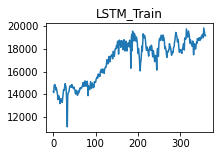

In [5]:
import matplotlib.pyplot as plt

domae = data['당해 도매 가격']

plt.gcf().set_size_inches(3, 2, forward=True)

start = 0
end = -1

real = plt.plot(domae[0:360], label='domae')

plt.title('LSTM_Train')
plt.show()

In [6]:
data_length = len(data['당해 도매 가격'].values)
print("data_length " , data_length)

seq_len = 21
sequence_length = seq_len + 1

result = []
for index in range(data_length - sequence_length):
  result.append(domae[index : index + sequence_length])

len(result)

data_length  1235


1213

In [7]:
normalized_data = []

idx = 0
for window in result: 
  # print('*' * 50)
  # print(window)
  normalized_window = [((float(p) / float(window[idx])) - 1) for p in window]
  normalized_data.append(normalized_window)
  # print(normalized_window)
  idx += 1

result = np.array(normalized_data)

In [8]:
# normalized_data = []

# idx = 0
# for window in result: 
#   normalized_window = [p for p in window]
#   normalized_data.append(normalized_window)
#   # print(normalized_window)
#   idx += 1

# result = np.array(normalized_data)

In [9]:
# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
print(train)
# np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]
print("x_train", x_train.shape)
print("y_train", y_train.shape)

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape



[[ 0.         -0.00680463  0.03528586 ... -0.04966678 -0.06103122
  -0.0680463 ]
 [ 0.          0.04237887  0.04802938 ... -0.05459811 -0.06166125
  -0.03588077]
 [ 0.          0.00542079  0.00684375 ... -0.09981027 -0.07507792
  -0.04621222]
 ...
 [ 0.          0.07408708 -0.1150515  ...  0.05705758  0.0684691
   0.04014513]
 [ 0.         -0.1760924  -0.00604773 ... -0.00523047 -0.03160074
  -0.11681377]
 [ 0.          0.20638804  0.1952784  ...  0.17537363  0.07194816
   0.20440418]]
x_train (1092, 21, 1)
y_train (1092,)


((1092, 21, 1), (121, 21, 1))

In [10]:
"""Build Model"""

model = Sequential()

model.add(LSTM(21, return_sequences=True, input_shape=(21, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 21)            1932      
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                22016     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 24,013
Trainable params: 24,013
Non-trainable params: 0
_________________________________________________________________


In [13]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping_callback = EarlyStopping(monitor='val_loss', patience = 100)


model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=2000,
    callbacks=[early_stopping_callback])

Epoch 1/2000
110/110 [==============================] - 2s 18ms/step - loss: 1.8286e-04 - val_loss: 0.0052
Epoch 2/2000
110/110 [==============================] - 2s 18ms/step - loss: 1.8531e-04 - val_loss: 0.0055
Epoch 3/2000
110/110 [==============================] - 2s 18ms/step - loss: 1.7645e-04 - val_loss: 0.0048
Epoch 4/2000
110/110 [==============================] - 2s 18ms/step - loss: 1.7457e-04 - val_loss: 0.0050
Epoch 5/2000
110/110 [==============================] - 2s 19ms/step - loss: 1.7224e-04 - val_loss: 0.0050
Epoch 6/2000
110/110 [==============================] - 2s 18ms/step - loss: 1.8121e-04 - val_loss: 0.0050
Epoch 7/2000
110/110 [==============================] - 2s 18ms/step - loss: 1.6208e-04 - val_loss: 0.0051
Epoch 8/2000
110/110 [==============================] - 2s 18ms/step - loss: 1.6305e-04 - val_loss: 0.0047
Epoch 9/2000
110/110 [==============================] - 2s 18ms/step - loss: 1.5817e-04 - val_loss: 0.0050
Epoch 10/2000
110/110 [==============

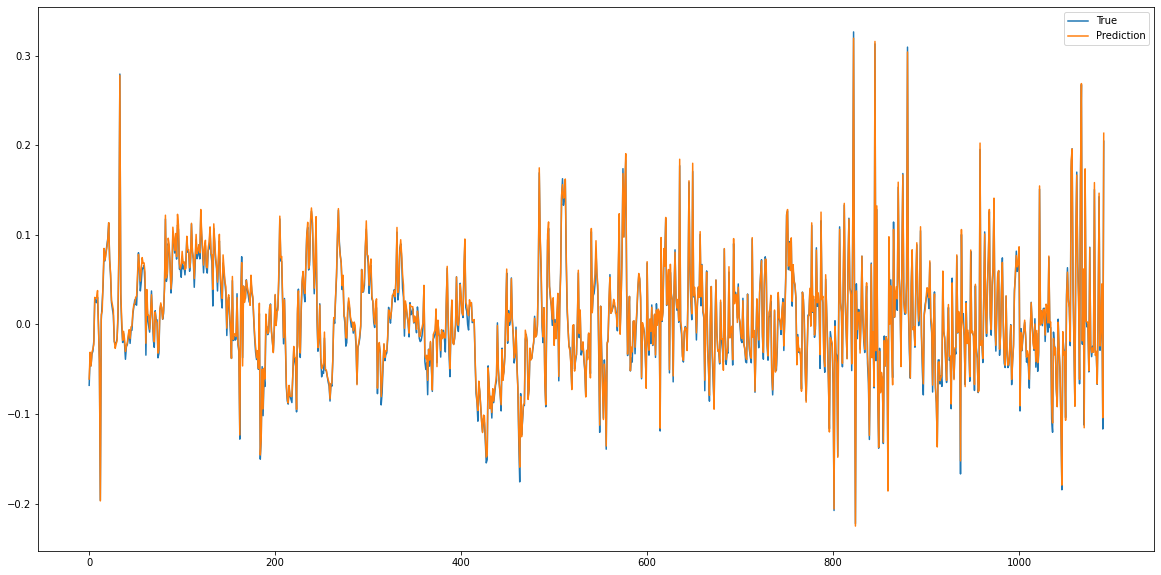

In [17]:
pred = model.predict(x_train)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_train, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

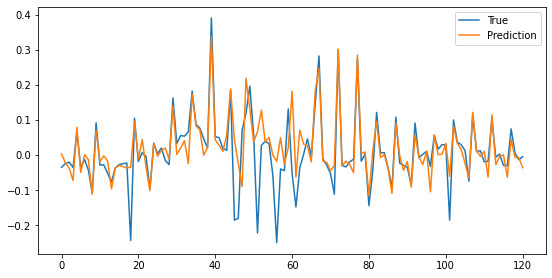

In [14]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(222)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()